In [8]:
import pickle
import pandas as pd
from utils.evaluator import plot_forecasted_series
import matplotlib.pyplot as plt

# Selección modelo

In [9]:
# --- Import the trained models ---

# Auto-arima
pickle_file_path = 'models/arima_model.pkl'

with open(pickle_file_path, 'rb') as file:
    # Load the content of the pickle file
    arima_models = pickle.load(file)

# XGBoost
pickle_file_path = 'models/xgboost_model.pkl'

with open(pickle_file_path, 'rb') as file:
    # Load the content of the pickle file
    xgboost_model = pickle.load(file)

# Tuned XGBoost
pickle_file_path = 'models/tuned_xgboost_model.pkl'

with open(pickle_file_path, 'rb') as file:
    # Load the content of the pickle file
    tuned_xgboost_model = pickle.load(file)


# --- Read trips data ---
trips_preprocessed = pd.read_csv('trips_preprocessed')

## Visualizar pronósticos para cada cuadrante

Graficamos la serie de viajes por día para cada cuadrante. De Enero a Octubre son los datos que se usaron para entrenar, y noviembre y diciembre para predecir. Para los meses de evaluación, se grafica el valor pronosticado (Forecast) contra el real (Test Data).

### XGBoost

Podemos ver que la serie pronosticada por XGBoost logra reflejar la disminución de viajes hacia fin de año, aunque sobre-estima especialmente una semana con menos viajes de lo normal (la ante última semana del año). 

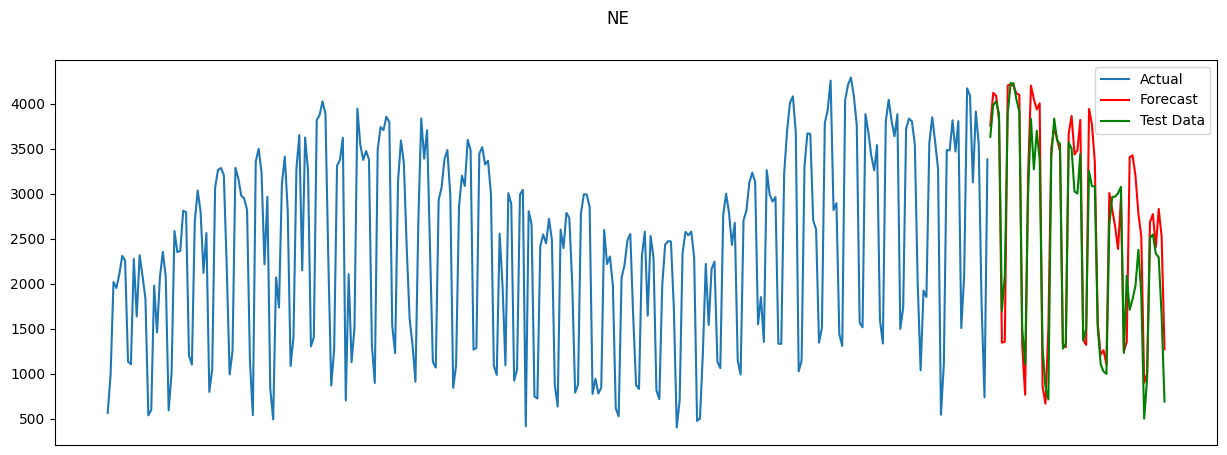

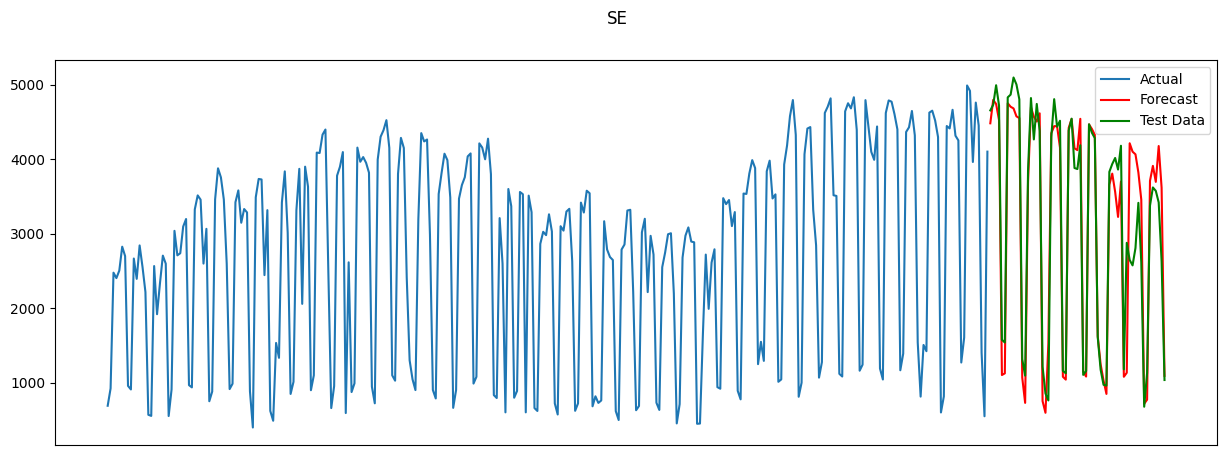

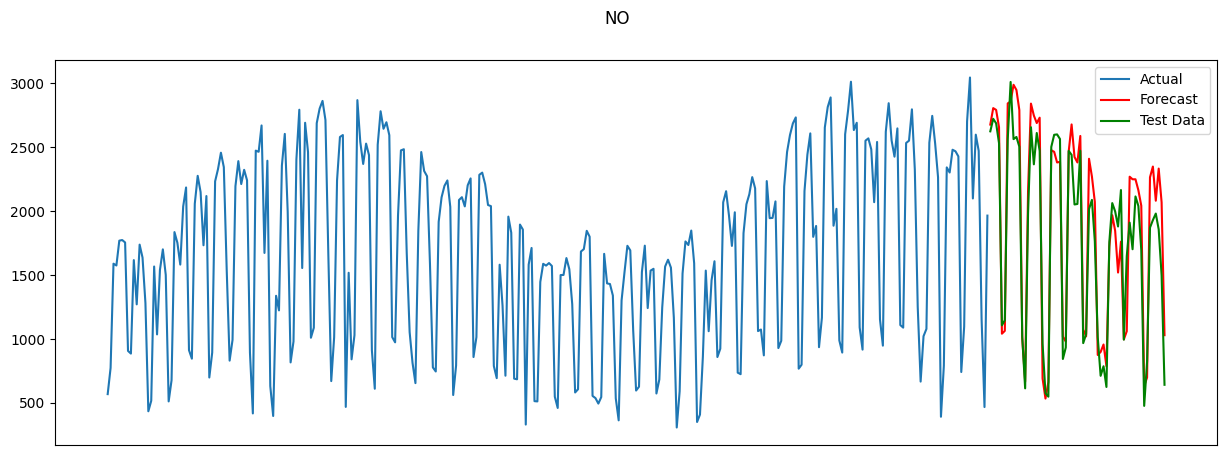

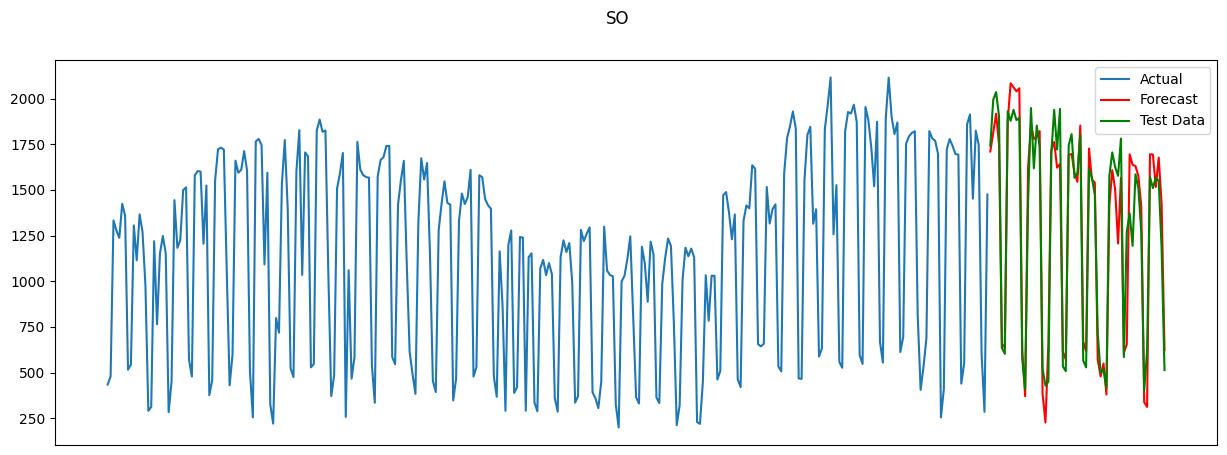

In [10]:
forecast_xgb = pd.DataFrame()
y_true_results = pd.DataFrame()

for quadrant in trips_preprocessed['quadrant'].unique():

    model = xgboost_model
    trips = trips_preprocessed[trips_preprocessed.quadrant==quadrant]
    trips = trips.sort_values(by='date_formatted')

    y_true = trips[trips.date_formatted>='2022-11-01'].set_index('date_formatted')['trips']
    y_train = trips[trips.date_formatted<'2022-11-01'].set_index('date_formatted')['trips']

    X = trips[trips.date_formatted>='2022-11-01'].drop(columns='trips')

    forecast = model.predict(X)
    forecast = pd.Series(forecast, index=y_true.index)

    plt.figure(figsize=(15,5))
    plt.suptitle(quadrant)
    plt.xticks([])
    plot_forecasted_series(y_train, forecast, y_true)
    
    df_forecast_xgb = pd.DataFrame(data=forecast, columns=['trips'])
    df_forecast_xgb['quadrant']=quadrant
    df_ytrue = pd.DataFrame(y_true)
    df_ytrue['quadrant']=quadrant

    forecast_xgb = forecast_xgb.append(df_forecast_xgb)
    y_true_results = y_true_results.append(df_ytrue)

    

### XGBoost - Tuning

A simple vista el modelo con hiperparametros tuneados es muy similar al original. Recordemos además que las métricas de evaluación también eran muy similares (hasta un poco peores).

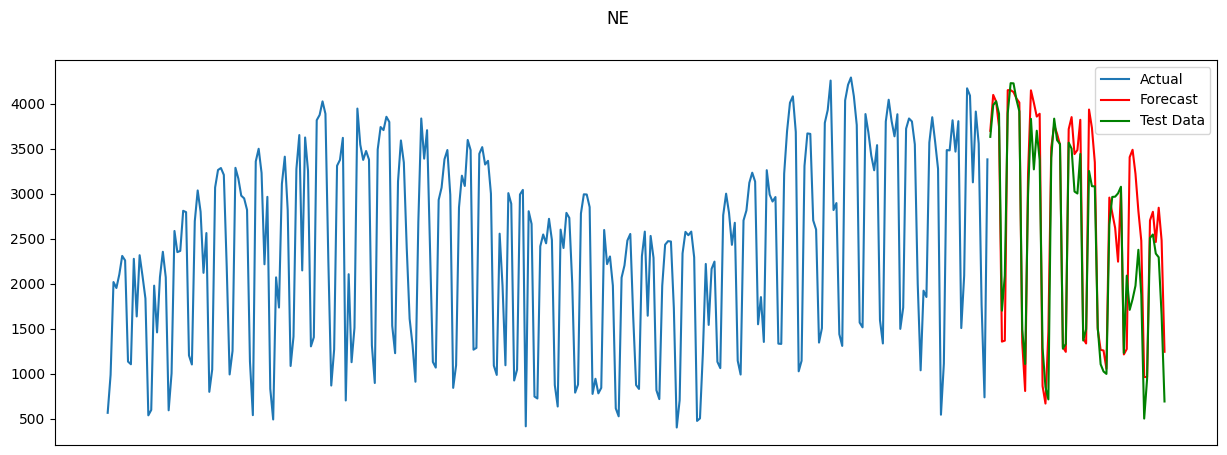

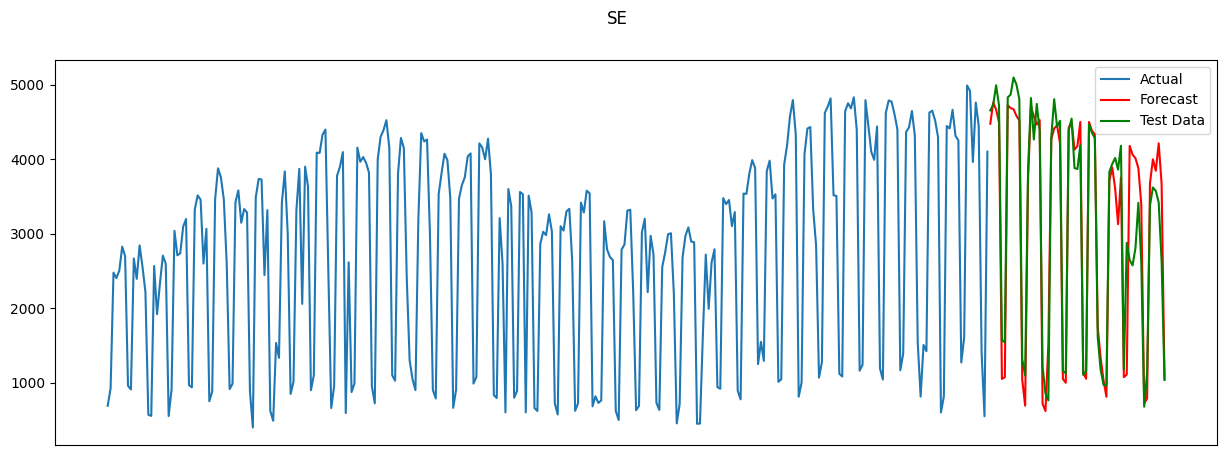

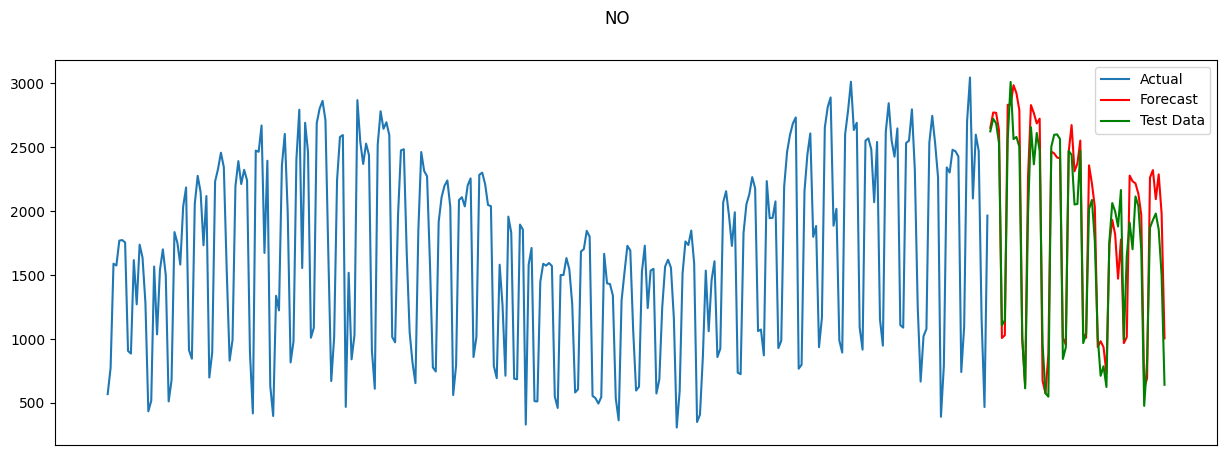

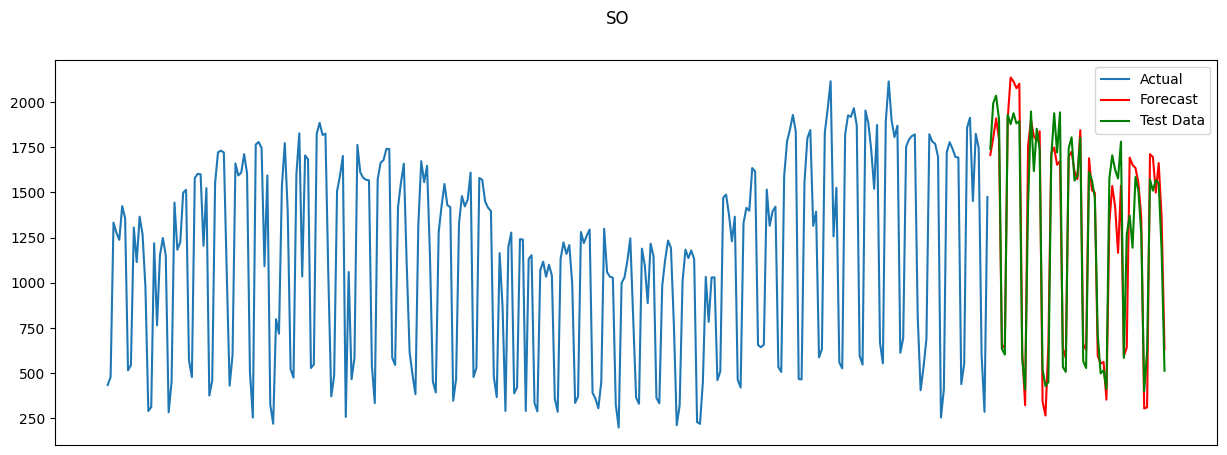

In [11]:
forecast_xgb_tune = pd.DataFrame()

for quadrant in trips_preprocessed['quadrant'].unique():

    model = tuned_xgboost_model
    trips = trips_preprocessed[trips_preprocessed.quadrant==quadrant]
    trips = trips.sort_values(by='date_formatted')

    y_true = trips[trips.date_formatted>='2022-11-01'].set_index('date_formatted')['trips']
    y_train = trips[trips.date_formatted<'2022-11-01'].set_index('date_formatted')['trips']

    X = trips[trips.date_formatted>='2022-11-01'].drop(columns='trips')

    forecast = model.predict(X)
    forecast = pd.Series(forecast, index=y_true.index)

    plt.figure(figsize=(15,5))
    plt.suptitle(quadrant)
    plt.xticks([])
    plot_forecasted_series(y_train, forecast, y_true)

    df_forecast_xgb_tune = pd.DataFrame(data=forecast, columns=['trips'])
    df_forecast_xgb_tune['quadrant']=quadrant

    forecast_xgb_tune = forecast_xgb_tune.append(df_forecast_xgb_tune)


### Auto-Arima

Podemos identificar que el modelo tiene un error grande especialmente en el cuadrante NORESTE. Hay que aclarar que este modelo fue entrenado con datos de enero a octubre, por lo cual no puede capturar bien la estacionalidad anual que vimos en el análisis exploratorio. 
Por otro lado se está buscando predecir 2 meses completos (Nov y Dic) solo con datos hasta Octubre, lo cual no es eficiente ya que el modelo no puede utilizar la información real de los viajes de la última semana (como si tiene la evaluación de XGBoost)

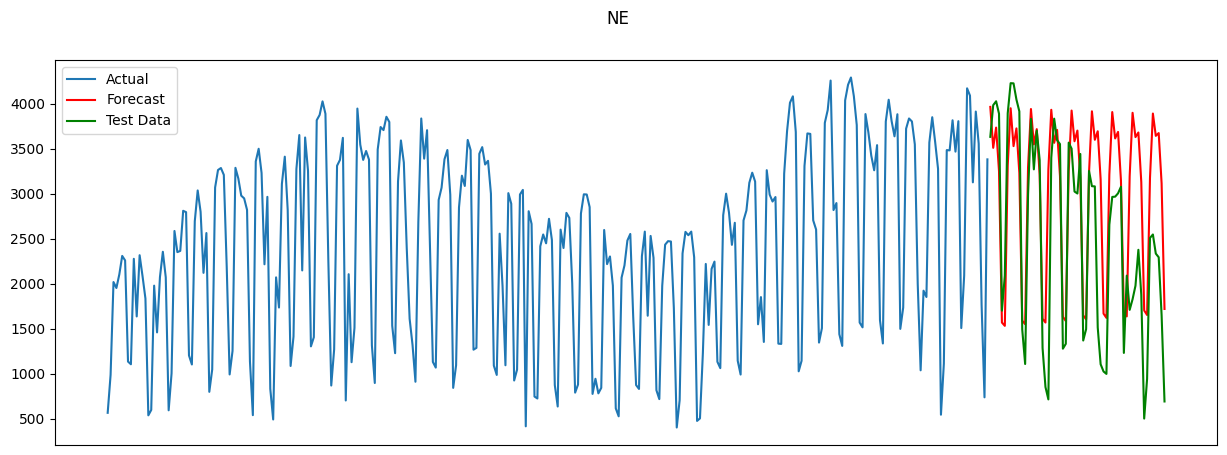

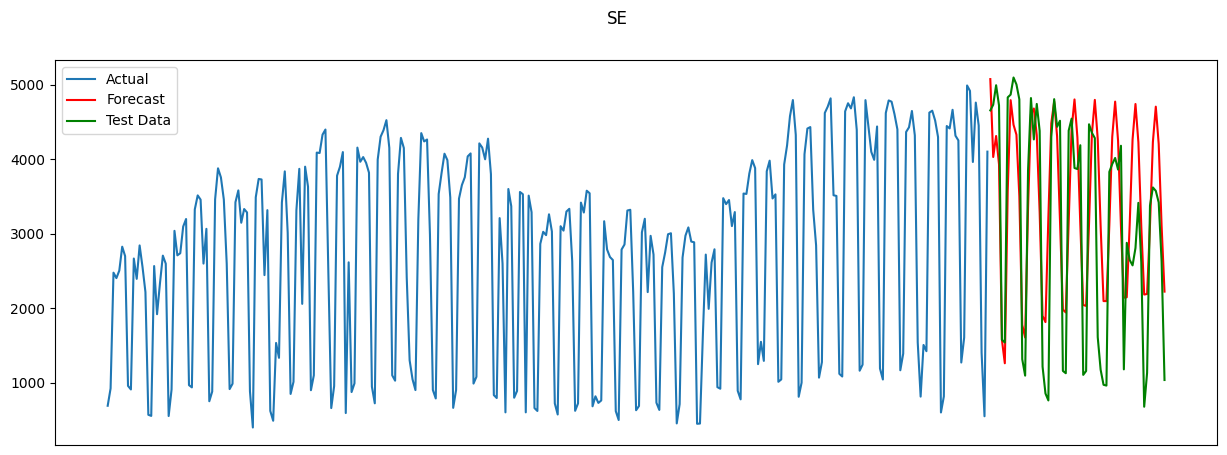

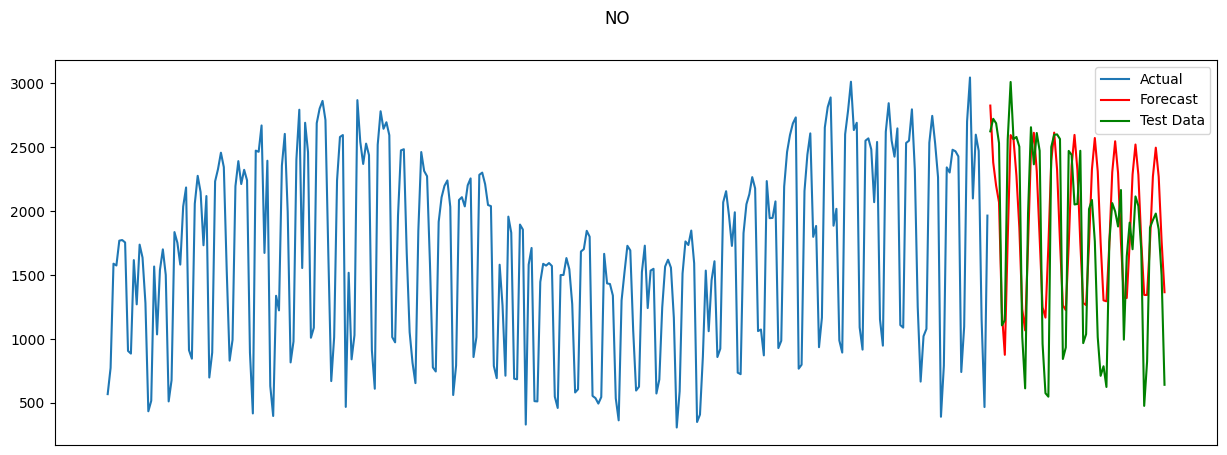

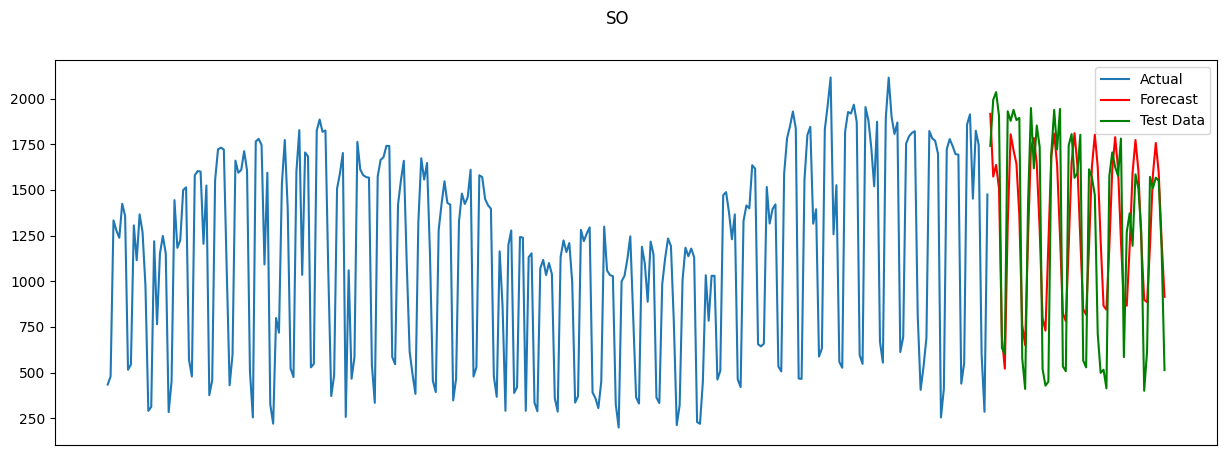

In [12]:


for quadrant in trips_preprocessed['quadrant'].unique():

    model = arima_models[quadrant]

    forecast, conf_int = arima_models[quadrant].predict(61, return_conf_int=True)
    train_days = 365 - 61

    trips = trips_preprocessed[trips_preprocessed.quadrant==quadrant]

    y_true = trips[trips.date_formatted>='2022-11-01'].set_index('date_formatted').sort_index()['trips']
    y_train = trips[trips.date_formatted<'2022-11-01'].set_index('date_formatted').sort_index()['trips']

    plt.figure(figsize=(15,5))
    plt.suptitle(quadrant)
    plt.xticks([])
    plot_forecasted_series(y_train, forecast, y_true)


In [13]:
#
df_results = forecast_xgb_tune.reset_index().merge(forecast_xgb.reset_index(), on=['date_formatted','quadrant'], suffixes=('_xgb', '_xgb_tune'))
df_results = df_results.reset_index().merge(y_true_results, on=['date_formatted','quadrant'])

df_results['error_xgb'] = df_results['trips_xgb'] - df_results['trips']
df_results['error_xgb_tune'] = df_results['trips_xgb_tune'] - df_results['trips']

Se descarta el modelo auto-arima debido al considerable error que tiene en las predicciones. El modelo XGBoost tiene mejor performance. Si bien no se logró una mejora durante el tuneo de hiperparámetros, se puede continuar optimizando con otras combinaciones, por ejemplo haciendo un grid search, para llegar a mejorar la performance. Además, se puede probar con distintas combinaciones de features. 

Por último se realiza un análisis de normalidad de los errores de los modelos XGBoost con un pp plot. Vemos que el error tiene algo de desvío vs la distribución normal, y que es muy similar tanto para el modelo tuneado como no.

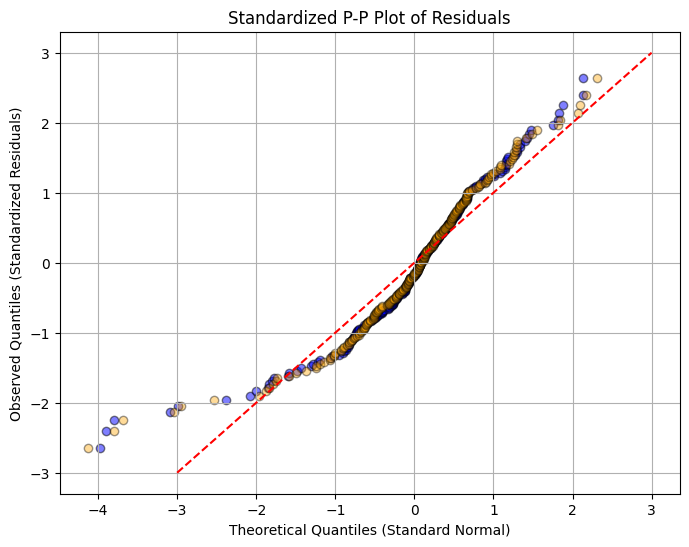

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


# Calculate residuals (errors)
residuals = df_results['trips'] - df_results['trips_xgb_tune']

# Standardize residuals
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Generate expected quantiles from a standard normal distribution
expected_quantiles = np.linspace(0, 1, len(residuals))

# Sort the standardized residuals
sorted_z_scores = np.sort(z_scores)

# Create the P-P plot
plt.figure(figsize=(8, 6))
plt.scatter(sorted_z_scores, stats.norm.ppf(expected_quantiles), color='blue', edgecolors='k', alpha=0.5)
plt.title('Standardized P-P Plot of Residuals')
plt.xlabel('Theoretical Quantiles (Standard Normal)')
plt.ylabel('Observed Quantiles (Standardized Residuals)')
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--', label='Identity Line')  # Identity line
plt.grid(True)


# Add for xgboost

# Calculate residuals (errors)
residuals = df_results['trips'] - df_results['trips_xgb']

# Standardize residuals
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Generate expected quantiles from a standard normal distribution
expected_quantiles = np.linspace(0, 1, len(residuals))

# Sort the standardized residuals
sorted_z_scores = np.sort(z_scores)

# Create the P-P plot
plt.scatter(sorted_z_scores, stats.norm.ppf(expected_quantiles), color='orange', edgecolors='k', alpha=0.4)
plt.show()

